In [16]:
import numpy as np
import pandas as pd
import re, string
import nltk
import spacy
import pickle
from tqdm import tqdm
from bs4 import BeautifulSoup
from prettytable import PrettyTable  # To print in a table

import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("/content/drive/MyDrive/combined_sarcastic.csv")

In [5]:
df.head(2)

,Question,Answer
0,How many Reddit admins does it take to change ...,"None, they like to keep the mods in the dark."
1,How many police officers does it take to chang...,"None, because they'll just beat the room for b..."


In [8]:
df.shape

(304486, 2)

### Utility Functions

In [28]:
def basic_statistics (columns, data=df):
    """
    Return basic statistics like min, max and others
    """
    x = PrettyTable()
    header = ["stats"] + columns
    result = {'minimum':[], 'maximum':[], 'mean':[], 'median':[], '25th per':[],
              '50th per':[], '75th per':[], '90th per':[], '95th per':[], '99th per':[]}

    for col in columns:
        col_val = data[col].values
        # Getting stats for the column
        result['minimum'].append(np.round(col_val.min(),2))
        result['maximum'].append(np.round(col_val.max(),2))
        result['mean'].append(np.round(np.mean(col_val),2))
        result['median'].append(np.round(np.median(col_val),2))
        for p in [25, 50, 75, 90, 95, 99]:
            result[str(p)+"th per"].append(np.round(np.percentile(col_val, p),2))
    
    # Printing results in a table
    x.field_names = header
    for tup in result.items():
        x.add_row([tup[0]]+tup[1])
    print(x)



#---------------------------------------------------------------
# Plotting Series
#---------------------------------------------------------------
def plot_func(columns, xlabel, ylabel, title, data=df, header=["Question", "Answer"]):
    """
    Plots pdf and boxplot on the given data
    """
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(18, 6))
    
    # Adding subplots
    pdf = fig.add_subplot(1,2,1)
    box = fig.add_subplot(1,2,2)
    
    # pdf/distplot
    pdf.set(title=title, xlabel=xlabel, ylabel=ylabel)
    for col in columns:
        sns.distplot(data[col].values, hist=True, rug=True, ax=pdf, label=col)
    pdf.legend()
    
    # boxplot
    box.set(title=title, ylabel=xlabel)
    sns.boxplot(data=data[columns], ax=box, orient='v')
    box.set_xticklabels(columns)
    
    plt.plot()

In [9]:
def decontractions(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [10]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)

In [12]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [13]:
def remove_emoticons(text):
    " Remove emoticons from text"
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

In [14]:
def clean_text(text):
    """
    This function clean the given data and preprocess it.
    """
    # Lower casting
    text = text.lower()

    # Remove all the mentions (words starting with '@')
    text = re.sub(r"@\S+", '', text)

    # Remove URL
    text = re.sub(r"http\S+", "", text)

    # Remove html tags
    text = BeautifulSoup(text, 'lxml').get_text()

    # Decontracted
    text = decontractions(text)

    # Remove emoji
    text = remove_emoji(text)

    # Remove emoticons
    text = remove_emoticons(text)

    # Remove words with digit
    text = re.sub("\S*\d\S*", "", text).strip()

    # Remove any special charecters and punctuations
    text = re.sub("[^A-Za-z\n]", " ", text)

    # Remove more than 1 space
    text = " ".join(text.split())

    return text

In [17]:
tqdm.pandas() #For progress bar

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [18]:
#Cleaning questions
df['QuestionClean'] = df['Question'].progress_apply(clean_text)

 48%|████▊     | 145511/304486 [00:51<00:57, 2743.00it/s]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 85%|████████▌ | 258827/304486 [01:31<00:15, 2913.46it/s]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 304486/304486 [01:47<00:00, 2836.92it/s]


In [25]:
#Cleaning answers
df.Answer = df.Answer.astype(str)
df['AnswerClean'] = df['Answer'].progress_apply(clean_text)



100%|██████████| 304486/304486 [02:32<00:00, 1992.37it/s]


In [29]:
df.shape

(304486, 4)

#Number of Words and More





In [30]:
df['qsn_len'] = df['QuestionClean'].apply(lambda x: len(x.split()))
df['ans_len'] = df['AnswerClean'].apply(lambda x: len(x.split()))

In [31]:
basic_statistics(["qsn_len", "ans_len"])

+----------+---------+---------+
|  stats   | qsn_len | ans_len |
+----------+---------+---------+
| minimum  |    0    |    0    |
| maximum  |    66   |   7783  |
|   mean   |   9.21  |  27.29  |
|  median  |   9.0   |   7.0   |
| 25th per |   6.0   |   4.0   |
| 50th per |   9.0   |   7.0   |
| 75th per |   11.0  |   15.0  |
| 90th per |   14.0  |   69.0  |
| 95th per |   17.0  |  144.0  |
| 99th per |   25.0  |  303.0  |
+----------+---------+---------+


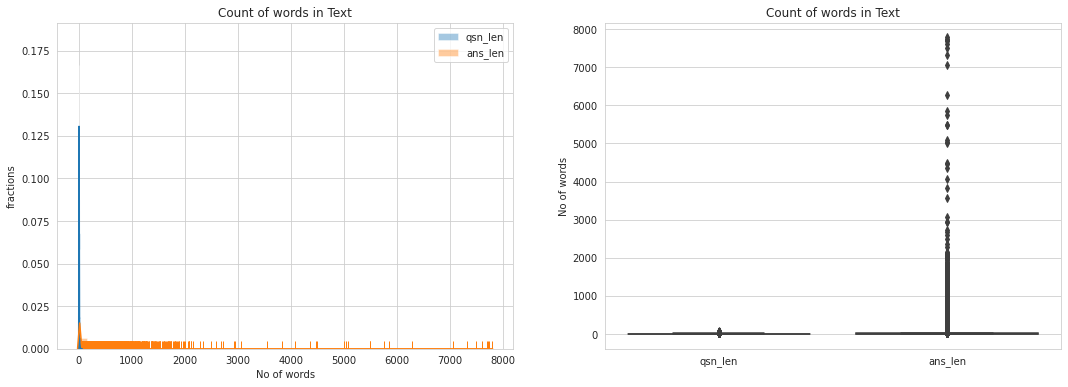

In [32]:
plot_func(['qsn_len', 'ans_len'], 'No of words', 'fractions', 'Count of words in Text')

In [35]:

def no_common_words(col1, col2, data=df):
    " Number of common words in both the columns "
    len_common = []
    for ind, row in tqdm(data.iterrows()):
        qsn_set = set(row[col1].split())
        ans_set = set(row[col2].split())

        common_words = qsn_set.intersection(ans_set)
        len_common.append(len(common_words))

    return len_common

In [37]:
df['len_common'] = no_common_words('QuestionClean', 'AnswerClean')



0it [00:00, ?it/s]

306it [00:00, 3059.56it/s]

1296it [00:00, 3859.26it/s]

2259it [00:00, 4704.79it/s]

3275it [00:00, 5607.95it/s]

4292it [00:00, 6479.80it/s]

5313it [00:00, 7276.32it/s]

6311it [00:00, 7919.34it/s]

7361it [00:00, 8549.02it/s]

8344it [00:00, 8895.77it/s]

9390it [00:01, 9312.15it/s]

10442it [00:01, 9642.14it/s]

11497it [00:01, 9895.71it/s]

12516it [00:01, 9890.79it/s]

13543it [00:01, 10000.23it/s]

14592it [00:01, 10141.13it/s]

15617it [00:01, 10050.28it/s]

16653it [00:01, 10139.99it/s]

17673it [00:01, 10057.47it/s]

18683it [00:01, 9868.75it/s] 

19674it [00:02, 9801.94it/s]

20658it [00:02, 9810.87it/s]

21699it [00:02, 9982.47it/s]

22700it [00:02, 9936.10it/s]

23696it [00:02, 9911.19it/s]

24689it [00:02, 9419.24it/s]

25707it [00:02, 9633.28it/s]

26708it [00:02, 9741.66it/s]

27756it [00:02, 9951.27it/s]

28810it [00:02, 10119.01it/s]

29861it [00:03, 10231.26it/s]

30907it [00:03, 10297.26it/s]

31939it [00:03, 10213.54it/s]

32962it [00:03, 100

In [38]:
basic_statistics(['len_common'])

+----------+------------+
|  stats   | len_common |
+----------+------------+
| minimum  |     0      |
| maximum  |     44     |
|   mean   |    1.38    |
|  median  |    1.0     |
| 25th per |    0.0     |
| 50th per |    1.0     |
| 75th per |    2.0     |
| 90th per |    4.0     |
| 95th per |    6.0     |
| 99th per |    9.0     |
+----------+------------+


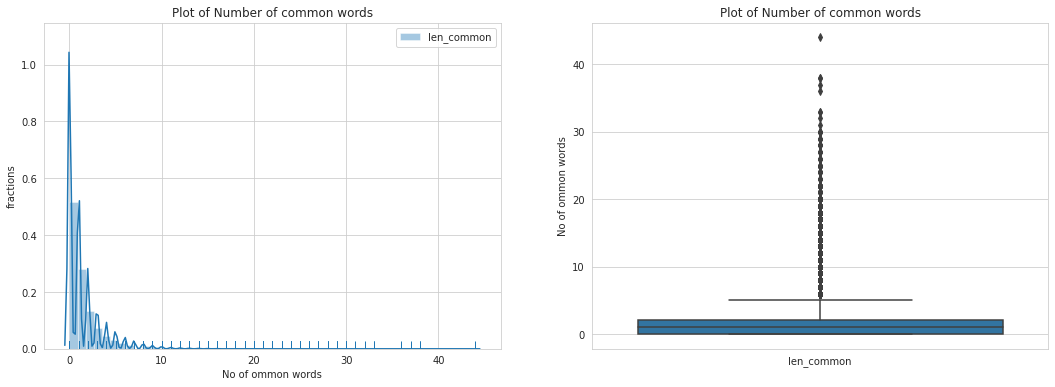

In [39]:
plot_func(['len_common'], 'No of ommon words', 'fractions', 'Plot of Number of common words')

In [43]:

from collections import Counter

qsn_cnt = Counter()
for text in df['QuestionClean'].values:
    for word in text.split():
        qsn_cnt[word] += 1


ans_cnt = Counter()
for text in df['AnswerClean'].values:
    for word in text.split():
        ans_cnt[word] += 1

In [44]:
qsn_cnt.most_common(25)

[('a', 157390),
 ('the', 124917),
 ('what', 87978),
 ('is', 74937),
 ('you', 74008),
 ('do', 56689),
 ('to', 56623),
 ('and', 43360),
 ('i', 41855),
 ('in', 38981),
 ('did', 35398),
 ('why', 35114),
 ('of', 32170),
 ('how', 27078),
 ('my', 23036),
 ('call', 20997),
 ('does', 20554),
 ('it', 19771),
 ('are', 19053),
 ('with', 18049),
 ('not', 18021),
 ('have', 17994),
 ('on', 17310),
 ('an', 16553),
 ('when', 16317)]

In [45]:

most_cmn = {k for k,v in qsn_cnt.most_common(50)}

In [46]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [47]:
print(set(stop_words).intersection(most_cmn))
print(len(set(stop_words).intersection(most_cmn)))

{'i', 'my', 'it', 'into', 'of', 'his', 'can', 'he', 'did', 'an', 'who', 'to', 'not', 'so', 'are', 'between', 'your', 'that', 'do', 'when', 'have', 'a', 'me', 'what', 'for', 'does', 'if', 'the', 'how', 'about', 'with', 'on', 'in', 'at', 'why', 'was', 'you', 'is', 'and'}
39


1.Looking for most frequent words in questions.<br>
2.After looking the words we can see that most of them are stopwords.<br>
3.Found that top 25 words are all stopwords and among top 50 most common words total 39 words are stopwords.

In [52]:
df.to_csv('NLP_sarcastic_totalCleaned.csv',index = False)

In [50]:
df.head()

,Question,Answer,QuestionClean,AnswerClean,qsn_len,ans_len,len_common
0,How many Reddit admins does it take to change ...,"None, they like to keep the mods in the dark.",how many reddit admins does it take to change ...,none they like to keep the mods in the dark,11,10,1
1,How many police officers does it take to chang...,"None, because they'll just beat the room for b...",how many police officers does it take to chang...,none because they will just beat the room for ...,12,11,0
2,How many Kings of Spain does it take to screw ...,A: Juan,how many kings of spain does it take to screw ...,a juan,14,2,1
3,How many Alzheimer's patients does it take to ...,TO GET TO THE OTHER SIDE!,how many alzheimer is patients does it take to...,to get to the other side,14,6,1
4,How many people does it take to change a light...,A Brazillion!!! http://imgur.com/c4CJjUd,how many people does it take to change a light...,a brazillion,13,2,1


In [51]:
df.shape

(304486, 7)